In [1]:
from fastMONAI.vision_all import *

from monai.apps import DecathlonDataset
from sklearn.model_selection import train_test_split

In [2]:
path = Path('../data/processed')
path.mkdir(exist_ok=True)

In [3]:
path = Path('../data/processed/IXI_2d_slices/')
fnames = get_image_files(path / "Axial")
masks = get_image_files(path / "AxialMask")

In [4]:
training_data = []
i = 0
for x in fnames:
    training_data.append([x, masks[0]])
    i = i+1

In [5]:
df = pd.DataFrame(training_data)
df.shape

(581, 2)

In [6]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=24)
train_df.shape, test_df.shape

((522, 2), (59, 2))

In [7]:
med_dataset = MedDataset(img_list=masks, dtype=MedMask, max_workers=12)

In [8]:
med_dataset.df.head()

,path,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,voxel_count_0,voxel_count_2,...,voxel_count_7,voxel_count_46,voxel_count_85,voxel_count_26,voxel_count_58,voxel_count_255,voxel_count_8,voxel_count_47,voxel_count_251,voxel_count_15
0,../data/processed/IXI_2d_slices/AxialMask/IXI491-Guys-1032-2d_axial-mask.png,256,256,1,1.0,1.0,1.0,LPS+,56610,1828,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,../data/processed/IXI_2d_slices/AxialMask/IXI126-HH-1437-2d_axial-mask.png,256,256,1,1.0,1.0,1.0,LPS+,55960,2139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,../data/processed/IXI_2d_slices/AxialMask/IXI389-Guys-0930-2d_axial-mask.png,256,256,1,1.0,1.0,1.0,LPS+,56056,2075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,../data/processed/IXI_2d_slices/AxialMask/IXI477-IOP-1141-2d_axial-mask.png,256,256,1,1.0,1.0,1.0,LPS+,56971,1758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,../data/processed/IXI_2d_slices/AxialMask/IXI278-HH-1771-2d_axial-mask.png,256,256,1,1.0,1.0,1.0,LPS+,54092,2447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
summary_df = med_dataset.summary()

In [10]:
summary_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
0,256,256,1,1.0,1.0,1.0,LPS+,../data/processed/IXI_2d_slices/AxialMask/IXI002-Guys-0828-2d_axial-mask.png,581


In [11]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([1.0, 1.0, 1.0], False)

In [12]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[256.0, 256.0, 1.0]

In [13]:
bs=1
size=[256,256,256]

In [14]:
item_tfms = [ZNormalization(), PadOrCrop(size), RandomAffine(scales=0, degrees=5, isotropic=True)] 

In [44]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=RandomSplitter(seed=24),
                      get_x=ColReader([0]),
                      get_y=ColReader([1]),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [45]:
dls = dblock.dataloaders(train_df, bs=bs)

In [46]:
# training and validation
len(dls.train_ds.items), len(dls.valid_ds.items)

(418, 104)

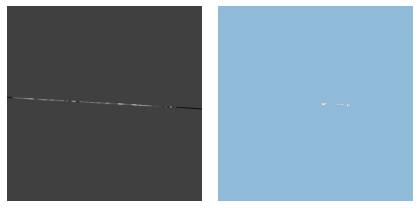

In [57]:
dls.show_batch(max_n=9, anatomical_plane=0) 

### Create and train a 3D model

In [19]:
from monai.losses import DiceCELoss
from monai.networks.nets import UNet

In [20]:
codes = np.loadtxt(path/'code-kopi_kuttet.txt', dtype=str)
n_classes = len(codes)
codes, n_classes

(array([['0', 'Unknown', '0', '0', '0', '0\\'],
        ['1', 'Left-Cerebral-Exterior', '70', '130', '180', '0\\'],
        ['2', 'Left-Cerebral-White-Matter', '245', '245', '245', '0\\'],
        ...,
        ['702', 'GrayMatter-FSL-FAST', '205', '62', '78', '0\\'],
        ['703', 'WhiteMatter-FSL-FAST', '0', '225', '0', '0\\'],
        ['999', 'SUSPICIOUS', '255', '100', '100', '0\\']], dtype='<U39'),
 374)

In [21]:
model = UNet(spatial_dims=3, in_channels=4, out_channels=n_classes, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), num_res_units=2)
model = model

In [22]:
loss_func = CustomLoss(loss_func=DiceCELoss(to_onehot_y=True, include_background=True, softmax=True))

In [23]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=multi_dice_score)#.to_fp16()

In [24]:
learn.lr_find()

RuntimeError: Given groups=1, weight of size [16, 4, 3, 3, 3], expected input[1, 1, 256, 256, 256] to have 4 channels, but got 1 channels instead

In [ ]:
lr = 1e-1

In [ ]:
learn.fit_flat_cos(20 ,lr)

In [ ]:
learn.save('fastMONAI-model')

In [ ]:
learn.show_results(anatomical_plane=0, ds_idx=1)